<a href="https://colab.research.google.com/github/kevinmoore9/EC-219-Project-1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports and helper functions

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer
# nltk.download('all')
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier




def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter


In [ ]:
df = pd.read_csv("/content/sample_data/Project1-ClassificationDataset.csv")
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


In [ ]:
# QUESTION 1
rows, cols = df.shape
print(f'samples: {rows}', f'features: {cols}')

samples: 3476 features: 8


52087


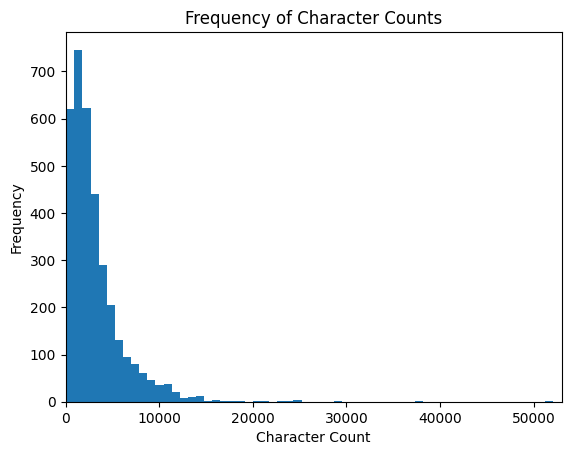

In [ ]:
char_counts = df['full_text'].apply(lambda x: len(clean(x)))
print(max(char_counts))

plt.hist(char_counts, bins=60)
plt.xlim(0,53000)
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.title("Frequency of Character Counts")
plt.show()


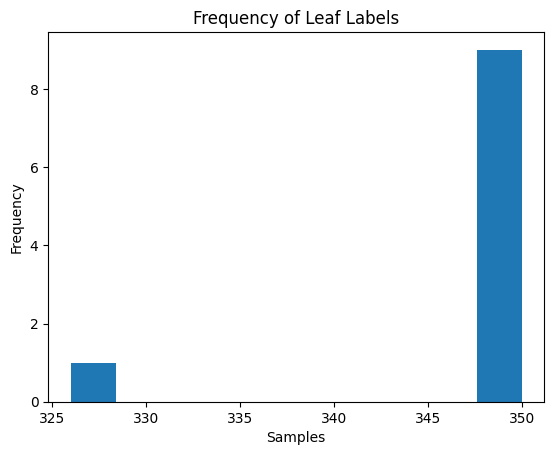

In [ ]:
leaf_counts = df["leaf_label"].value_counts()
plt.hist(leaf_counts)
plt.xlabel("Samples")
plt.ylabel("Frequency")
plt.title("Frequency of Leaf Labels")
plt.show()

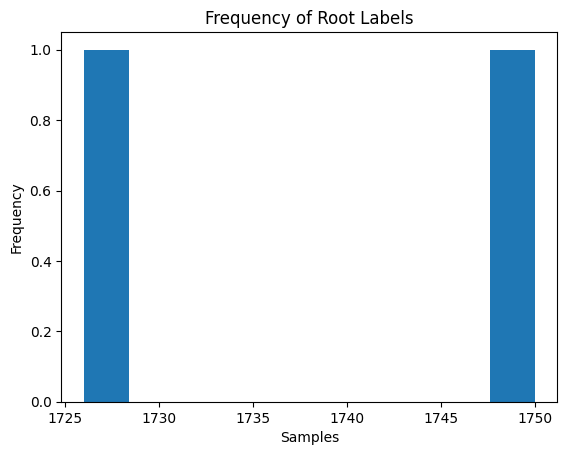

In [ ]:
root_counts = df["root_label"].value_counts()
plt.hist(root_counts)
plt.xlabel("Samples")
plt.ylabel("Frequency")
plt.title("Frequency of Root Labels")
plt.show()

The above plots indicate the following:
1. There is a nearly-even distribution of samples across each of the 10 leaf classes, with only one class having ~22 samples less than the other 8.
2. One of the root classes has about 20 more samples than the other.
3. The majority of the samples have word counts under 10,000, with an even higher concentration below 5,000.

# Binary Classification

In [ ]:
# QUESTION 2

np.random.seed(42)
random.seed(42)
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
train= train.reset_index(drop=True)
test=  test.reset_index(drop=True)
f'Training Samples: {len(train)}, Testing Samples: {len(test)}'

'Training Samples: 2780, Testing Samples: 696'

**Feature Extraction**

In [ ]:
# QUESTION 3
# clean and exclude numbers
train["full_text"], test["full_text"] = train["full_text"].apply(lambda x: clean(x)), test["full_text"].apply(lambda x: clean(x))
train["full_text"], test["full_text"] = train["full_text"].apply(lambda x: re.sub(r"\d+", "", x)), test["full_text"].apply(lambda x: re.sub(r"\d+", "", x))
train.head()


,full_text,root_label
0,'While the four-day Aftershock's economic impa...,climate
1,'CBS Essentials is created independently of th...,sports
2,'Moderate-to-severe drought will likely contin...,climate
3,"'Colleen Flood, the longtime co-owner of The F...",climate
4,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,sports


In [ ]:
# english stopwords, min_df=3
## UPDATE the order of lemmatizing and removing stop words



analyzer = CountVectorizer(min_df=3, stop_words="english").build_analyzer()
train["lemmatized"], test["lemmatized"] = train["full_text"].apply(lambda x: analyzer(x)), test["full_text"].apply(lambda x: analyzer(x))
train.head()

# lemmetization
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize(text):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
          for word, tag in pos_tag(nltk.word_tokenize(text))]

train["lemmatized"], test["lemmatized"] = train["lemmatized"].apply(lambda x: lemmatize(" ".join(x))), test["lemmatized"].apply(lambda x: lemmatize(" ".join(x)))
train["lemmatized"], test["lemmatized"] = train["lemmatized"].apply(lambda x: ' '.join(x)), test["lemmatized"].apply(lambda x: ' '.join(x))
train.head()

,full_text,root_label,lemmatized
0,'While the four-day Aftershock's economic impa...,climate,day aftershock economic impact million day gol...
1,'CBS Essentials is created independently of th...,sports,cbs essential create independently cbs news ed...
2,'Moderate-to-severe drought will likely contin...,climate,moderate severe drought likely continue expand...
3,"'Colleen Flood, the longtime co-owner of The F...",climate,colleen flood longtime owner trey tavern pour ...
4,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,sports,washington traffic save life yeah good basebal...


In [ ]:
vectorizer = CountVectorizer(stop_words="english", min_df=3)
train_vect = vectorizer.fit_transform(train["lemmatized"])
print(train_vect.shape)

test_vect = vectorizer.transform(test["lemmatized"])
print(test_vect.shape)

(2780, 13357)
(696, 13357)


In [ ]:
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_vect)
test_tfidf = tfidf_transformer.transform(test_vect)

print(train_tfidf.shape)
print(test_tfidf.shape)

(2780, 13357)
(696, 13357)


Question 3:

**What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?**
Stemming is much faster since it simply truncates the words to their stem. This is a good option if speed is more important than accuracy. Stemming can cause words with different contextual meanings to be seen as the same word. ie saw (past tense see) and saw (tool)
Lemmatization is slower but consideres grammar and context of the word. This will better preserve the meaning of the sentence as a whole.

Stemming may reduce the size of the dictonary more than lemmatization if it reduces the same word into multiple lemmas (ie, saw -> see & saw)

**min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?**
Using a higher min-df will cause the dictonary to only include words that are used in a higher number of documents. This will reduce your dictonary matrix to only include more rare words. In some cases, these words may be more valuable in predicting the meaning of the document.

**Should I remove stopwords before or after lemmatizing?**
You should remove stopwords after lemmatizing. This is because the words could turn into stopwords after they are in their lemma form and thus further reduce your document.

**Should I remove punctuations before
or after lemmatizing?**
You should remove punctuation after lemmatizing, so that words preserve their true meaning when lemmatizing.

**Should I remove numbers before or after lemmatizing?**
You should remove numbers before lemmatizing, so that it does not interfere with the meaning of the word.

**Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2. The number of columns should roughly be in the order of
k ×103. This dimension will vary depending on your exact method of cleaning and lemmatizing**
and that is okay
(2780, 13357)
(696, 13357)

**Dimensationality Reduction**

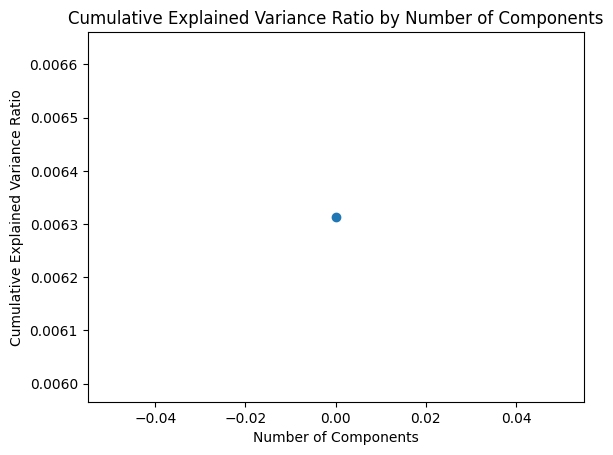

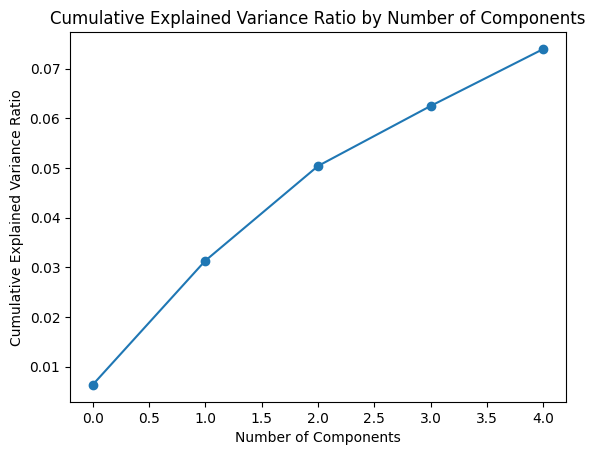

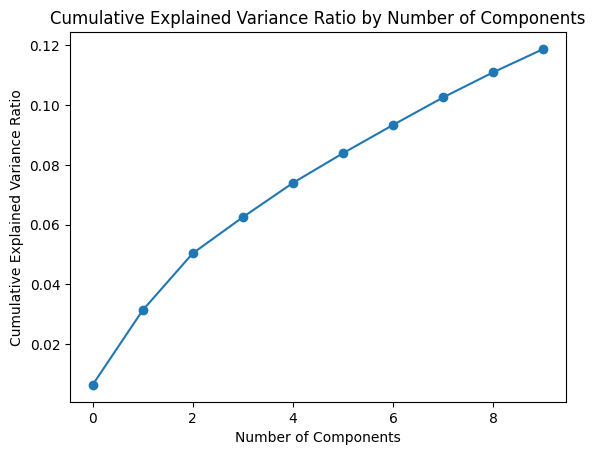

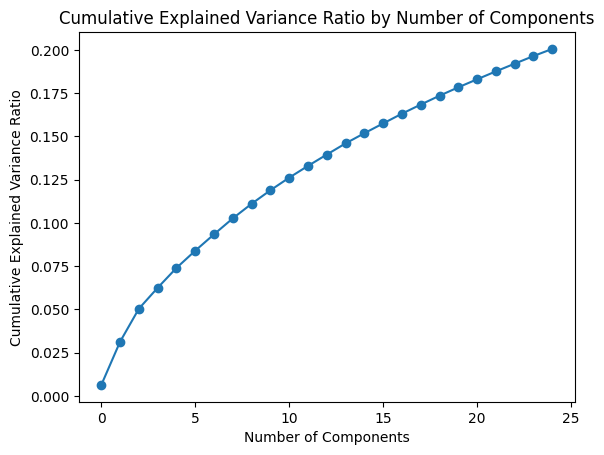

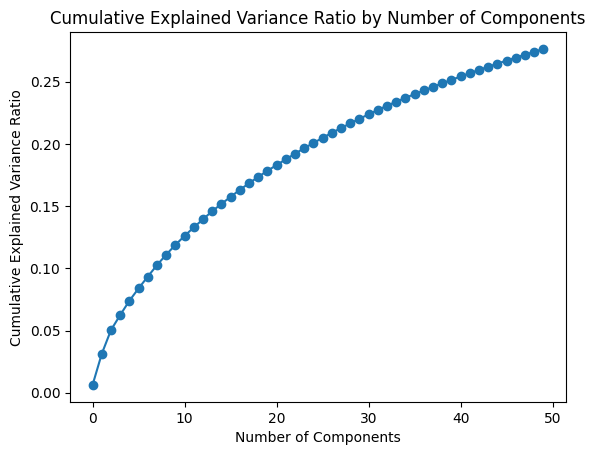

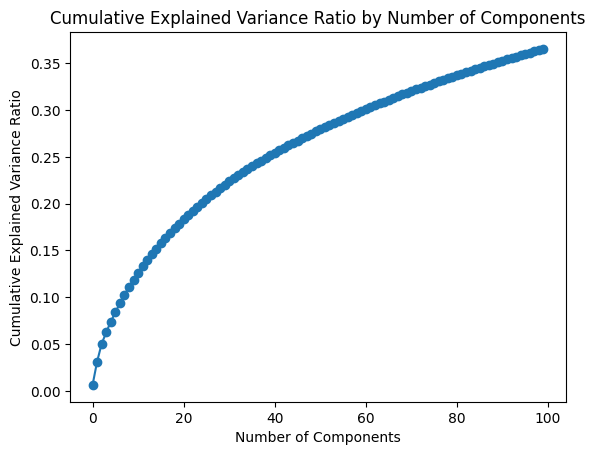

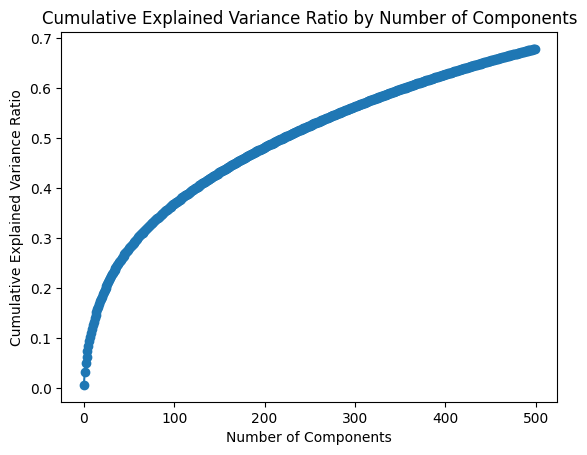

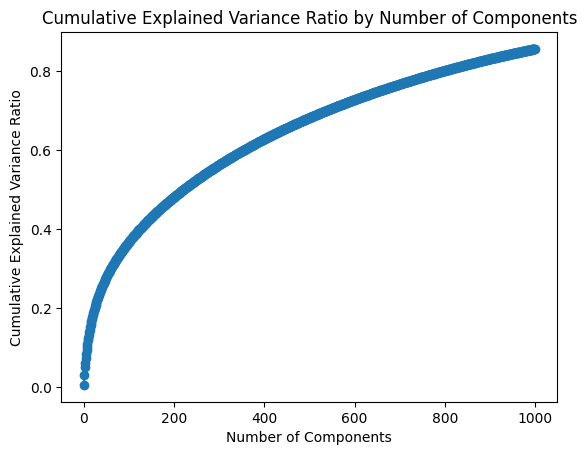

In [ ]:
# QUESTION 4
#LSI
k = [1,5,10,25,50,100,500,1000]
for k in k:
  svd = TruncatedSVD(n_components=k, random_state=42)
  train_reduced = svd.fit_transform(train_tfidf)
  test_reduced = svd.transform(test_tfidf)


  cumulative_variance_ratio = np.cumsum(svd.explained_variance_ratio_)
  plt.plot(cumulative_variance_ratio, marker='o')
  plt.xlabel('Number of Components')
  plt.ylabel('Cumulative Explained Variance Ratio')
  plt.title('Cumulative Explained Variance Ratio by Number of Components')
  plt.show()


**Question 4:**

**What does the explained variance ratio plot look like? What does the plot’s concavity suggest**
The explained variance curve looks like a logarithmic curve with a quick rise and gradual leveling off. The concavity suggests that each additional component provides a diminishing increase of explained variance.

In [ ]:
# calculate reconstruction residual w/ k = 25
# LSI

svd = TruncatedSVD(n_components=25, random_state=42)
x_train = svd.fit_transform(train_tfidf)
lsi_mse = mean_squared_error(train_tfidf.toarray(), svd.inverse_transform(x_train))
print(f'LSI MSE: {lsi_mse}')

# NMF
nmf = NMF(n_components=25, random_state=42)
x_train = nmf.fit_transform(train_tfidf.toarray())
nmf_dot = np.dot(x_train, nmf.components_)
nmf_mse = mean_squared_error(train_tfidf.toarray(), nmf_dot)
print(f'NMF MSE: {nmf_mse}')


LSI MSE: 5.79133389515536e-05
NMF MSE: 5.828834327838256e-05


The NMF MSE is larger. This is typically because NMF is constrained to positive values.

# Classification Algorithms

SVM

Hard Margin Resuluts:
Accuracy Score: 0.9353448275862069
Recall Score: 0.9402173913043478
Precision Score: 0.9376693766937669
F1 Score: 0.9389416553595658

Soft Margin Resuluts:
Accuracy Score: 0.8922413793103449
Recall Score: 0.8097826086956522
Precision Score: 0.9834983498349835
F1 Score: 0.8882265275707899

Very Hard Margin Resuluts:
Accuracy Score: 0.9353448275862069
Recall Score: 0.9402173913043478
Precision Score: 0.9376693766937669
F1 Score: 0.9389416553595658

Best Margin Resuluts:
Accuracy Score: 0.9382183908045977
Recall Score: 0.9456521739130435
Precision Score: 0.9380053908355795
F1 Score: 0.9418132611637348



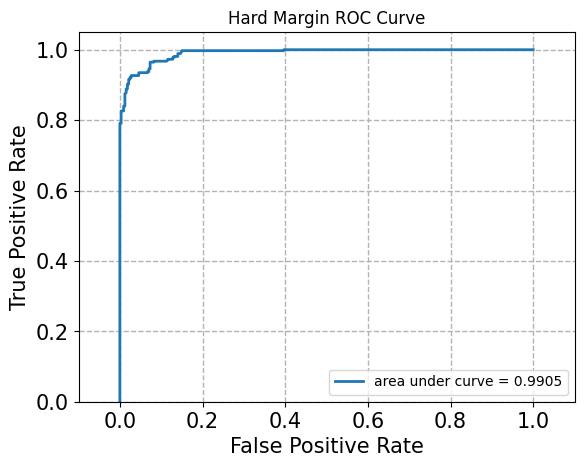

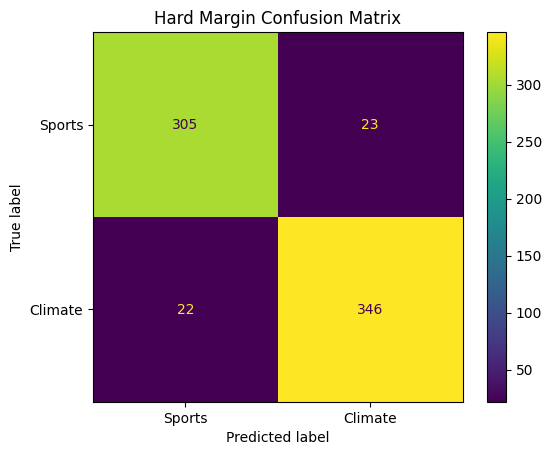

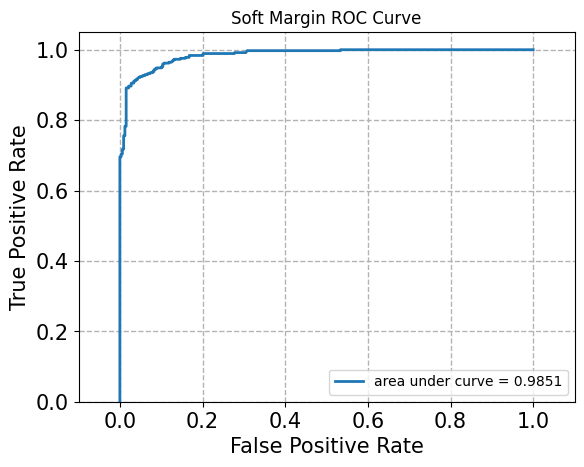

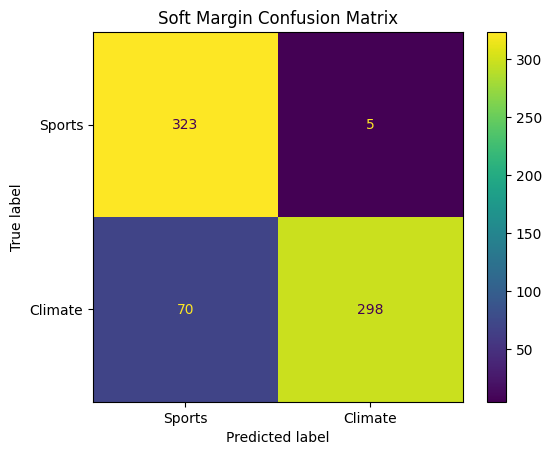

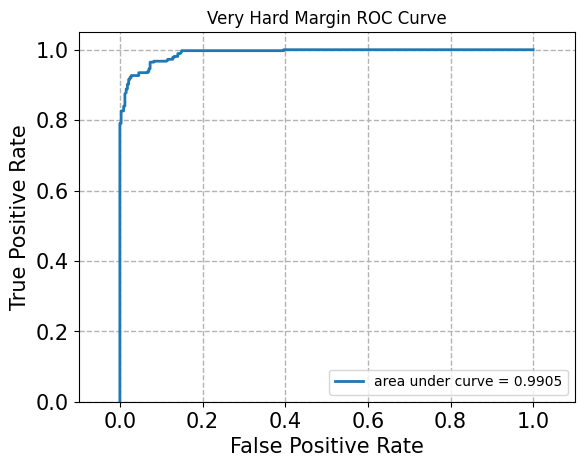

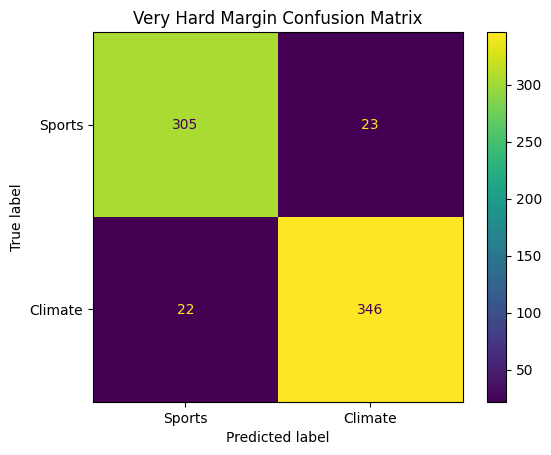

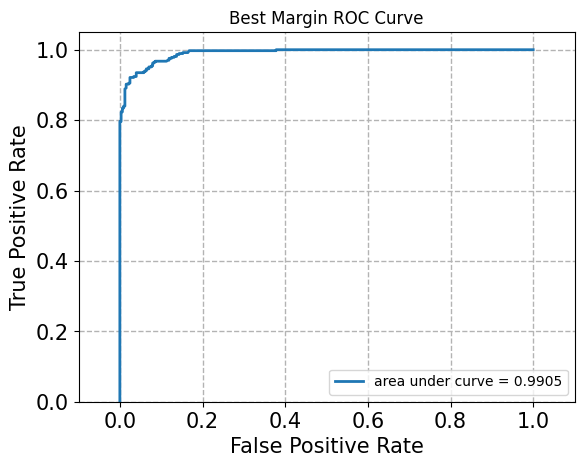

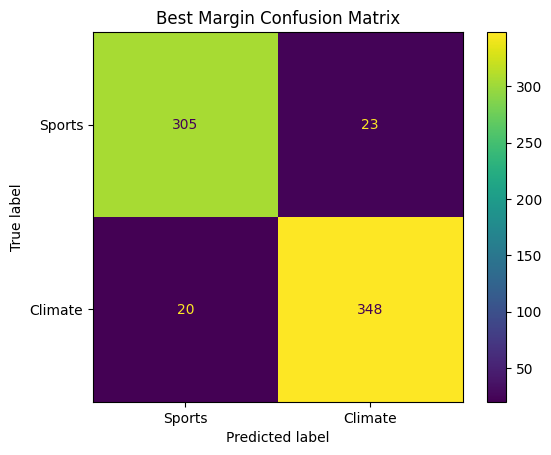

In [ ]:
# QUESTION 5:
# reset to k=25
svd = TruncatedSVD(n_components=25, random_state=42)
train_reduced = svd.fit_transform(train_tfidf)
test_reduced = svd.transform(test_tfidf)

for c in [2000, 0.00005, 100000, 10]: # 10 is best gamma calculated from next step. adding here for graph reusability
  svc_types = {2000: "Hard", 0.00005: "Soft", 100000: "Very Hard", 10: "Best"}

  svc = LinearSVC(C=c)
  predicted = svc.fit(train_reduced, train['root_label']).predict(test_reduced)
  prob_score = svc.decision_function(test_reduced)

  # plot ROC curve
  fpr, tpr, _ = roc_curve(test['root_label'], prob_score, pos_label='sports')
  fig, ax = plt.subplots()
  roc_auc = auc(fpr,tpr)

  ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

  ax.grid(color='0.7', linestyle='--', linewidth=1)

  ax.set_xlim([-0.1, 1.1])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate',fontsize=15)
  ax.set_ylabel('True Positive Rate',fontsize=15)
  ax.set_title(f'{svc_types[c]} Margin ROC Curve')

  ax.legend(loc="lower right")

  for label in ax.get_xticklabels()+ax.get_yticklabels():
      label.set_fontsize(15)

  # Confusion Matrix
  disp = ConfusionMatrixDisplay.from_estimator(
      svc,
      test_reduced,
      test["root_label"],
      display_labels = ["Sports", "Climate"]
  )
  disp.ax_.set_title(f'{svc_types[c]} Margin Confusion Matrix')


  print(f'{svc_types[c]} Margin Resuluts:')
  print(f'Accuracy Score: {accuracy_score(test["root_label"], predicted)}')
  print(f'Recall Score: {recall_score(test["root_label"], predicted, pos_label="sports")}')
  print(f'Precision Score: {precision_score(test["root_label"], predicted, pos_label="sports")}')
  print(f'F1 Score: {f1_score(test["root_label"], predicted, pos_label="sports")}')
  print('')

**QUESTION 5**

**What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.
Does the ROC curve reflect the performance of the soft-margin SVM? Why**

In this case, the soft margin SVM has a lower overall accuracy and the false positives are more skewed to one class. The hard margin has more balanced false positives and false negatives.

This could be from the soft margin allowing a greater error tolerance in order to preserve a smoother decision boundary.

The ROC curve does reflect both of these points. The soft margin ROC curve has more uniform curve, but also has a lower AOC.

In [ ]:
# Cross Validation

gamma_range = [10**k for k in range(-3, 7)]
param_grid = {'gamma': gamma_range, 'kernel': ['rbf']}


grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_reduced, train["root_label"])
gamma = grid_search.best_params_['gamma']
# gamma = 10
print(gamma)

10


Logistic Regression

Accuracy Score: 0.9382183908045977
Recall Score: 0.9402173913043478
Precision Score: 0.9427792915531336
F1 Score: 0.9414965986394558


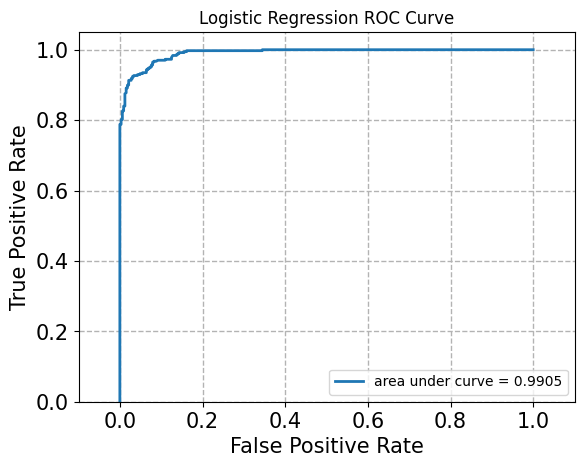

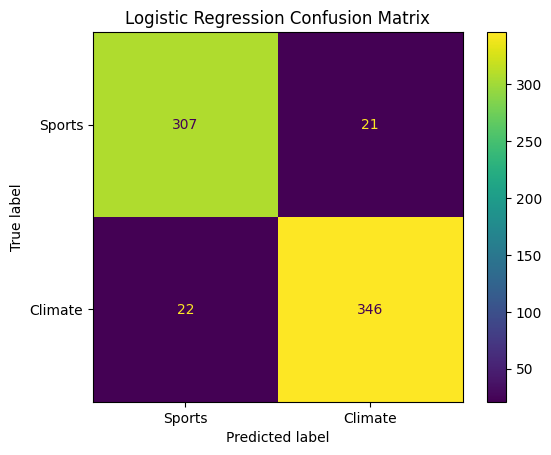

In [ ]:
# QUESTION 6:

log_clf = LogisticRegression(penalty=None, max_iter=10000,random_state=42)
log_clf.fit(train_reduced, train['root_label'])
pred = log_clf.predict(test_reduced)
prob_score = log_clf.decision_function(test_reduced)

 # plot ROC curve
fpr, tpr, _ = roc_curve(test['root_label'], prob_score, pos_label='sports')
fig, ax = plt.subplots()
roc_auc = auc(fpr,tpr)

ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

ax.grid(color='0.7', linestyle='--', linewidth=1)

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)
ax.set_title(f'Logistic Regression ROC Curve')

ax.legend(loc="lower right")
for label in ax.get_xticklabels()+ax.get_yticklabels():
      label.set_fontsize(15)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    log_clf,
    test_reduced,
    test["root_label"],
    display_labels = ["Sports", "Climate"]
)
disp.ax_.set_title('Logistic Regression Confusion Matrix')

print(f'Accuracy Score: {accuracy_score(test["root_label"], pred)}')
print(f'Recall Score: {recall_score(test["root_label"], pred, pos_label="sports")}')
print(f'Precision Score: {precision_score(test["root_label"], pred, pos_label="sports")}')
print(f'F1 Score: {f1_score(test["root_label"], pred, pos_label="sports")}')

In [ ]:
# L1, L2

C_range = [10**k for k in range(-5, 6)]
param_grid = {'C': C_range}

l1_clf = LogisticRegression(penalty='l1', max_iter=10000,random_state=42, solver="liblinear")
l1_grid = GridSearchCV(l1_clf, param_grid, cv=5, scoring="accuracy")
l1_grid.fit(train_reduced, train['root_label'])
l1_pred = l1_grid.best_estimator_.predict(test_reduced)

l2_clf = LogisticRegression(penalty='l2', max_iter=10000,random_state=42, solver="liblinear")
l2_grid = GridSearchCV(l2_clf, param_grid, cv=5, scoring="accuracy")
l2_grid.fit(train_reduced, train['root_label'])
l2_pred = l2_grid.best_estimator_.predict(test_reduced)

print(f'Best l1: {l1_grid.best_params_["C"]}')
print(f'Accuracy Score: {accuracy_score(test["root_label"], l1_pred)}')
print(f'Recall Score: {recall_score(test["root_label"], l1_pred, pos_label="sports")}')
print(f'Precision Score: {precision_score(test["root_label"], l1_pred, pos_label="sports")}')
print(f'F1 Score: {f1_score(test["root_label"], l1_pred, pos_label="sports")}')

print(f'Best l2: {l2_grid.best_params_["C"]}')
print(f'Accuracy Score: {accuracy_score(test["root_label"], l2_pred)}')
print(f'Recall Score: {recall_score(test["root_label"], l2_pred, pos_label="sports")}')
print(f'Precision Score: {precision_score(test["root_label"], l2_pred, pos_label="sports")}')
print(f'F1 Score: {f1_score(test["root_label"], l2_pred, pos_label="sports")}')

Best l1: 100
Accuracy Score: 0.9382183908045977
Recall Score: 0.9402173913043478
Precision Score: 0.9427792915531336
F1 Score: 0.9414965986394558
Best l2: 1000
Accuracy Score: 0.9382183908045977
Recall Score: 0.9402173913043478
Precision Score: 0.9427792915531336
F1 Score: 0.9414965986394558


**QUESTION 6**

**Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi-
fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best
parameters you found from the part above), using test data**

All three logistic classifiers have the same accuracy, recall, precision and f1 scores for their best classifiers. This is likely because we are using a hight C value which causes the model to have very little regularization.

Naive Bayes

Accuracy Score: 0.9181034482758621
Recall Score: 0.9728260869565217
Precision Score: 0.8839506172839506
F1 Score: 0.926261319534282


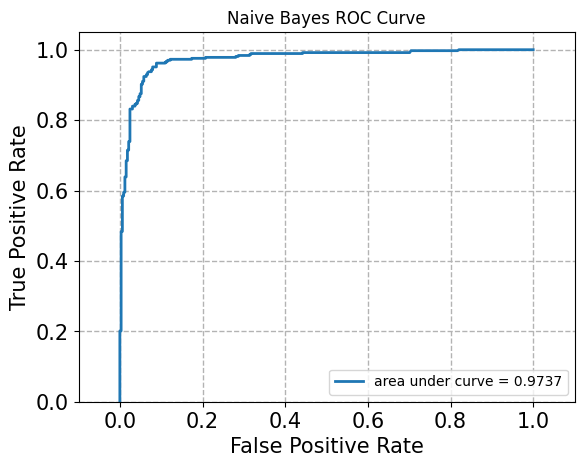

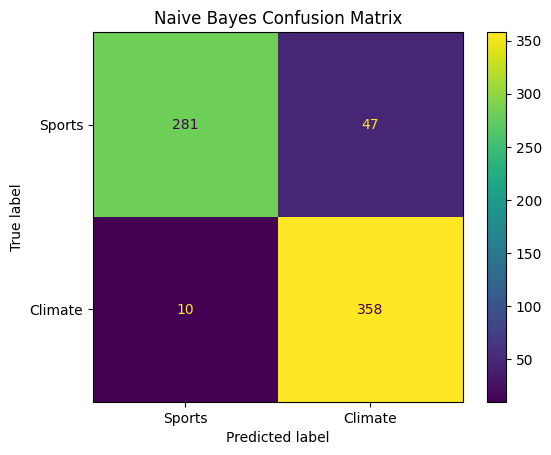

In [ ]:
# QUESTION 7

nb = GaussianNB()
nb.fit(train_reduced, train['root_label'])
pred = nb.predict(test_reduced)
prob_score = nb.predict_proba(test_reduced)[:,1]

 # plot ROC curve
fpr, tpr, _ = roc_curve(test['root_label'], prob_score, pos_label='sports')
fig, ax = plt.subplots()
roc_auc = auc(fpr,tpr)

ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

ax.grid(color='0.7', linestyle='--', linewidth=1)

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)
ax.set_title(f'Naive Bayes ROC Curve')

ax.legend(loc="lower right")
for label in ax.get_xticklabels()+ax.get_yticklabels():
      label.set_fontsize(15)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    nb,
    test_reduced,
    test["root_label"],
    display_labels = ["Sports", "Climate"]
)
disp.ax_.set_title('Naive Bayes Confusion Matrix')

print(f'Accuracy Score: {accuracy_score(test["root_label"], pred)}')
print(f'Recall Score: {recall_score(test["root_label"], pred, pos_label="sports")}')
print(f'Precision Score: {precision_score(test["root_label"], pred, pos_label="sports")}')
print(f'F1 Score: {f1_score(test["root_label"], pred, pos_label="sports")}')

**Grid Search of Parameters**

In [ ]:
pstemmer = PorterStemmer()


def stem(text):
  return [pstemmer.stem(word.lower()) for word in nltk.word_tokenize(text)]

train["stemmed"], test["stemmed"] = train["full_text"].apply(lambda x: " ".join(stem(x))), test["full_text"].apply(lambda x: " ".join(stem(x)))
# train["stemmed"], test["stemmed"] = train["full_text"].apply(lambda x: " ".join(stem(x))), test["full_text"].apply(lambda x: " ".join(stem(x)))
print(train.head())
# train["stemmed"], test["stemmed"] = train["stemmed"].apply(lambda x: ' '.join(x)), test["stemmed"].apply(lambda x: ' '.join(x))


                                           full_text root_label  \
0  'While the four-day Aftershock's economic impa...    climate   
1  'CBS Essentials is created independently of th...     sports   
2  'Moderate-to-severe drought will likely contin...    climate   
3  'Colleen Flood, the longtime co-owner of The F...    climate   
4  'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...     sports   

                                          lemmatized  \
0  day aftershock economic impact million day gol...   
1  cbs essential create independently cbs news ed...   
2  moderate severe drought likely continue expand...   
3  colleen flood longtime owner trey tavern pour ...   
4  washington traffic save life yeah good basebal...   

                                             stemmed  
0  'while the four-day aftershock 's econom impac...  
1  'cb essenti is creat independ of the cb news e...  
2  'moderate-to-sever drought will like continu t...  
3  'colleen flood , the longtim co-own o

In [ ]:
# QUESTION 8
best_gamma = 10
best_l1 = 100
best_l2 = 1000

l1_clf = LogisticRegression(penalty='l1', max_iter=10000,C=best_l1, random_state=42, solver="liblinear")
l2_clf = LogisticRegression(penalty='l2', max_iter=10000,C=best_l2, random_state=42, solver="liblinear")

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', None),
    ('clf', None)
])

N_FEATURES_OTPIONS = [5, 30, 100]

param_grid = [{
    'vect__min_df': (2,5),
    'reduce_dim': [NMF(), TruncatedSVD(random_state=42)],
    'reduce_dim__n_components': N_FEATURES_OTPIONS,
    'clf': [GaussianNB(), LinearSVC(C=best_gamma, random_state=42), l1_clf, l2_clf]
}]

grid_lem = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid_lem.fit(train['lemmatized'], train['root_label'])

grid_stem = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring="accuracy")
grid_stem.fit(train['stemmed'], train['root_label'])

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', None), ('clf', None)]),
             param_grid=[{'clf': [GaussianNB(),
                                  LinearSVC(C=10, random_state=42),
                                  LogisticRegression(C=100, max_iter=10000,
                                                     penalty='l1',
                                                     random_state=42,
                                                     solver='liblinear'),
                                  LogisticRegression(C=1000, max_iter=10000,
                                                     random_state=42,
                                                     solver='liblinear')],
                          'reduce_dim': [NMF(), TruncatedSVD(random_state=42)],
                          'reduce_dim__n_components': [5, 30, 100],
                          'vect__min_df': (2, 5)}],
             scoring='accuracy')

In [ ]:
# save results to dv
lem_results = pd.DataFrame(grid_lem.cv_results_)
lem_results['compression'] = "lemmatize"
stem_results = pd.DataFrame(grid_stem.cv_results_)
stem_results['compression'] = "stem"
# export to save


In [ ]:
lem_results.sort_values(by=["mean_test_score"], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_reduce_dim__n_components,param_vect__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,compression
29,53.150446,5.805613,0.427042,0.049061,"LogisticRegression(C=100, max_iter=10000, pena...",NMF(),100,5,"{'clf': LogisticRegression(C=100, max_iter=100...",0.955036,0.962230,0.956835,0.965827,0.958633,0.959712,0.003874,1,lemmatize
23,1.324925,0.017558,0.130511,0.012508,"LinearSVC(C=10, random_state=42)",TruncatedSVD(random_state=42),100,5,"{'clf': LinearSVC(C=10, random_state=42), 'red...",0.958633,0.965827,0.960432,0.951439,0.960432,0.959353,0.004635,2,lemmatize
28,62.077210,11.226603,0.517646,0.072948,"LogisticRegression(C=100, max_iter=10000, pena...",NMF(),100,2,"{'clf': LogisticRegression(C=100, max_iter=100...",0.956835,0.965827,0.955036,0.958633,0.956835,0.958633,0.003773,3,lemmatize
22,1.993098,0.505917,0.153207,0.035405,"LinearSVC(C=10, random_state=42)",TruncatedSVD(random_state=42),100,2,"{'clf': LinearSVC(C=10, random_state=42), 'red...",0.958633,0.962230,0.960432,0.949640,0.960432,0.958273,0.004464,4,lemmatize
47,1.411965,0.020654,0.127237,0.002694,"LogisticRegression(C=1000, max_iter=10000, ran...",TruncatedSVD(random_state=42),100,5,"{'clf': LogisticRegression(C=1000, max_iter=10...",0.958633,0.967626,0.953237,0.949640,0.962230,0.958273,0.006374,4,lemmatize


In [ ]:
stem_results.sort_values(by=["mean_test_score"], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_reduce_dim__n_components,param_vect__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,compression
23,1.826579,0.566000,0.194706,0.017922,"LinearSVC(C=10, random_state=42)",TruncatedSVD(random_state=42),100,5,"{'clf': LinearSVC(C=10, random_state=42), 'red...",0.956835,0.965827,0.960432,0.964029,0.960432,0.961511,0.003136,1,stem
47,1.609012,0.026741,0.181121,0.008118,"LogisticRegression(C=1000, max_iter=10000, ran...",TruncatedSVD(random_state=42),100,5,"{'clf': LogisticRegression(C=1000, max_iter=10...",0.955036,0.967626,0.958633,0.960432,0.964029,0.961151,0.004346,2,stem
29,47.531148,9.578362,0.760423,0.485598,"LogisticRegression(C=100, max_iter=10000, pena...",NMF(),100,5,"{'clf': LogisticRegression(C=100, max_iter=100...",0.955036,0.969424,0.964029,0.956835,0.958633,0.960791,0.005262,3,stem
22,1.877991,0.066485,0.202773,0.012674,"LinearSVC(C=10, random_state=42)",TruncatedSVD(random_state=42),100,2,"{'clf': LinearSVC(C=10, random_state=42), 'red...",0.956835,0.962230,0.962230,0.962230,0.960432,0.960791,0.002097,4,stem
35,1.934951,0.334125,0.199975,0.048995,"LogisticRegression(C=100, max_iter=10000, pena...",TruncatedSVD(random_state=42),100,5,"{'clf': LogisticRegression(C=100, max_iter=100...",0.955036,0.964029,0.956835,0.962230,0.962230,0.960072,0.003488,5,stem


In [ ]:
results = pd.concat([stem_results, lem_results])
results[["param_clf", "param_reduce_dim", "param_reduce_dim__n_components", "param_vect__min_df", "compression", "mean_test_score"]].sort_values(by=["mean_test_score"], ascending=False).head()

,param_clf,param_reduce_dim,param_reduce_dim__n_components,param_vect__min_df,compression,mean_test_score
23,"LinearSVC(C=10, random_state=42)",TruncatedSVD(random_state=42),100,5,stem,0.961511
47,"LogisticRegression(C=1000, max_iter=10000, ran...",TruncatedSVD(random_state=42),100,5,stem,0.961151
29,"LogisticRegression(C=100, max_iter=10000, pena...",NMF(),100,5,stem,0.960791
22,"LinearSVC(C=10, random_state=42)",TruncatedSVD(random_state=42),100,2,stem,0.960791
35,"LogisticRegression(C=100, max_iter=10000, pena...",TruncatedSVD(random_state=42),100,5,stem,0.960072


# Multiclass Classification

In [ ]:
# QUESTION 9
df = pd.read_csv("/content/sample_data/Project1-ClassificationDataset.csv")

map_row_to_class = {"basketball": 0, "baseball": 1, "tennis": 2,
"football": 3, "soccer": 4, "forest fire": 5, "flood": 6,
"earthquake": 7, "drought": 8, "heatwave": 9}

df['leaf_label'] = df['leaf_label'].apply(lambda x: map_row_to_class[x])
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,0,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,0,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,0,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,0,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,0,sports


In [ ]:
train, test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)
train= train.reset_index(drop=True)
test=  test.reset_index(drop=True)

# clean and drop numbers
train["full_text"], test["full_text"] = train["full_text"].apply(lambda x: clean(x)), test["full_text"].apply(lambda x: clean(x))
train["full_text"], test["full_text"] = train["full_text"].apply(lambda x: re.sub(r"\d+", "", x)), test["full_text"].apply(lambda x: re.sub(r"\d+", "", x))

In [ ]:
# lemmatize
train["lemmatized"], test["lemmatized"] = train["full_text"].apply(lambda x: analyzer(x)), test["full_text"].apply(lambda x: analyzer(x))
train["lemmatized"], test["lemmatized"] = train["lemmatized"].apply(lambda x: lemmatize(" ".join(x))), test["lemmatized"].apply(lambda x: lemmatize(" ".join(x)))
train["lemmatized"], test["lemmatized"] = train["lemmatized"].apply(lambda x: ' '.join(x)), test["lemmatized"].apply(lambda x: ' '.join(x))
train.head()

,full_text,leaf_label,lemmatized
0,'This article has been reviewed according to S...,7,article review accord science editorial proces...
1,'INDIANAPOLIS The Indiana Fever will pick No....,0,indianapolis indiana fever pick overall wnba d...
2,'MILAN (AP) Jannik Sinner will be looking to ...,2,milan ap jannik sinner look serve perfect dish...
3,'Map shows the most likely rainfall amounts ex...,6,map show likely rainfall amount expect south f...
4,'A .-magnitude earthquake was reported on the ...,7,magnitude earthquake report big island hawaii ...


In [ ]:
# vectorize
vectorizer = CountVectorizer(stop_words="english", min_df=3)
train_vect = vectorizer.fit_transform(train["lemmatized"])
test_vect = vectorizer.transform(test["lemmatized"])

tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_vect)
test_tfidf = tfidf_transformer.transform(test_vect)

print(train_tfidf.shape)
print(test_tfidf.shape)


(2780, 13716)
(696, 13716)


In [ ]:
svd = TruncatedSVD(n_components=25, random_state=42)
train_reduced = svd.fit_transform(train_tfidf)
test_reduced = svd.transform(test_tfidf)

**Naive Bayes**

Accuracy Score: 0.7413793103448276
Naive Bayes Classification Report:
              precision    recall  f1-score   support

  basketball       0.95      0.97      0.96        73
    baseball       0.82      0.89      0.85        65
      tennis       0.84      0.81      0.83        80
    football       0.89      0.81      0.85        70
      soccer       0.87      0.88      0.87        75
 forest fire       0.10      0.10      0.10        62
       flood       0.90      0.83      0.86        69
  earthquake       1.00      0.90      0.94        67
     drought       0.87      0.89      0.88        75
    heatwave       0.12      0.15      0.14        60

    accuracy                           0.74       696
   macro avg       0.74      0.72      0.73       696
weighted avg       0.76      0.74      0.75       696



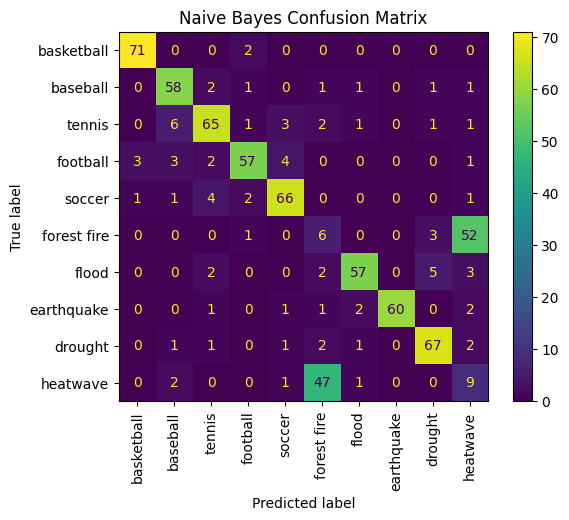

In [ ]:
nb = MultinomialNB()
nb.fit(train_vect, train["leaf_label"])
pred = nb.predict(test_vect)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    nb,
    test_vect,
    test["leaf_label"],
    display_labels = ["basketball", "baseball", "tennis",
"football", "soccer", "forest fire", "flood",
"earthquake", "drought", "heatwave"]
)
disp.ax_.set_title('Naive Bayes Confusion Matrix')
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)



print(f'Accuracy Score: {accuracy_score(test["leaf_label"], pred)}')
print("Naive Bayes Classification Report:")
print(classification_report(test['leaf_label'], pred, target_names=["basketball", "baseball", "tennis",
"football", "soccer", "forest fire", "flood",
"earthquake", "drought", "heatwave"]))

**One vs One SVM**

Accuracy Score: 0.7859195402298851
One v One SVM Classification Report:
              precision    recall  f1-score   support

  basketball       0.91      0.96      0.93        73
    baseball       0.74      0.80      0.77        65
      tennis       0.70      0.76      0.73        80
    football       0.90      0.93      0.92        70
      soccer       0.86      0.91      0.88        75
 forest fire       0.34      0.24      0.28        62
       flood       0.92      0.94      0.93        69
  earthquake       0.95      0.87      0.91        67
     drought       0.93      0.91      0.92        75
    heatwave       0.40      0.42      0.41        60

    accuracy                           0.79       696
   macro avg       0.77      0.77      0.77       696
weighted avg       0.78      0.79      0.78       696



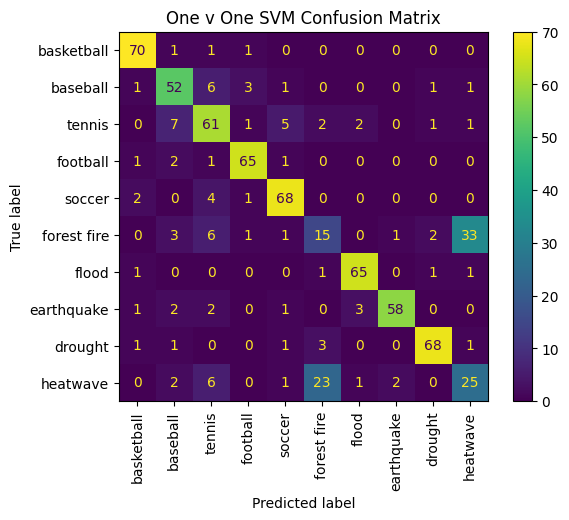

In [ ]:
one_svm = OneVsRestClassifier(LinearSVC(C=10, random_state=42))
one_svm.fit(train_reduced, train['leaf_label'])
pred = one_svm.predict(test_reduced)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    one_svm,
    test_reduced,
    test["leaf_label"],
    display_labels = ["basketball", "baseball", "tennis",
"football", "soccer", "forest fire", "flood",
"earthquake", "drought", "heatwave"]
)
disp.ax_.set_title('One v One SVM Confusion Matrix')
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)


print(f'Accuracy Score: {accuracy_score(test["leaf_label"], pred)}')
print("One v One SVM Classification Report:")
print(classification_report(test['leaf_label'], pred, target_names=["basketball", "baseball", "tennis",
"football", "soccer", "forest fire", "flood",
"earthquake", "drought", "heatwave"]))

**One vs Rest SVM**

Accuracy Score: 0.7931034482758621
One v Rest SVM Classification Report:
              precision    recall  f1-score   support

  basketball       0.97      0.95      0.96        73
    baseball       0.73      0.86      0.79        65
      tennis       0.67      0.78      0.72        80
    football       0.96      0.91      0.93        70
      soccer       0.87      0.92      0.90        75
 forest fire       0.37      0.27      0.31        62
       flood       0.94      0.90      0.92        69
  earthquake       0.94      0.88      0.91        67
     drought       0.93      0.91      0.92        75
    heatwave       0.42      0.43      0.43        60

    accuracy                           0.79       696
   macro avg       0.78      0.78      0.78       696
weighted avg       0.79      0.79      0.79       696



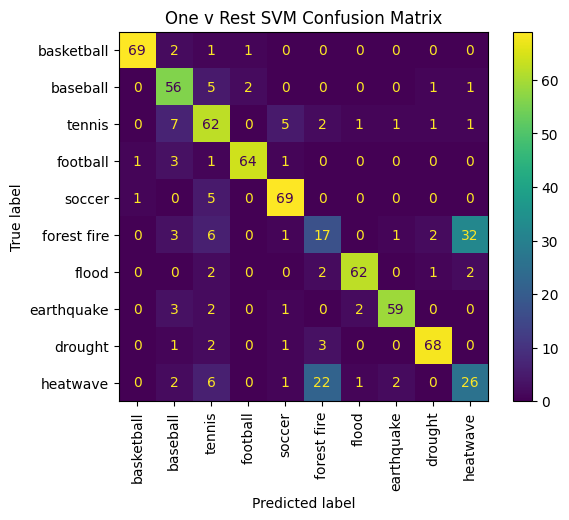

In [ ]:
rest_svm = OneVsRestClassifier(LinearSVC(random_state=42, C=10, class_weight='balanced'))
rest_svm.fit(train_reduced, train['leaf_label'])
pred = rest_svm.predict(test_reduced)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    rest_svm,
    test_reduced,
    test["leaf_label"],
    display_labels = ["basketball", "baseball", "tennis",
"football", "soccer", "forest fire", "flood",
"earthquake", "drought", "heatwave"]
)
disp.ax_.set_title('One v Rest SVM Confusion Matrix')
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)


print(f'Accuracy Score: {accuracy_score(test["leaf_label"], pred)}')
print("One v Rest SVM Classification Report:")
print(classification_report(test['leaf_label'], pred, target_names=["basketball", "baseball", "tennis",
"football", "soccer", "forest fire", "flood",
"earthquake", "drought", "heatwave"]))

**Merged Labels**

Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the
major diagonal? What does this mean?

We see blocks of similarly related classes, mostly in the top left corner. This indicates that sports are correctly being identified as a sport, but they are frequently being misclassified as the wrong sport.

Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
Why did you choose these labels?

In the above confusion matrix, we see that most labels are being accurately predicted, however "heatwave" and "forest fire" are being commonly missclassified with one another. This indicates the classes may be too similar for our model to accurately predict the difference between them. We can try to remedy this and improve our accuracy by combining these into a single class "heat".



In [ ]:
train.head()

,full_text,leaf_label,lemmatized
0,'Monday's reported earthquake comes days afte...,7,monday report earthquake come day magnitude ea...
1,'Utah State Aggies safety Ike Larsen () celebr...,1,utah state aggies safety ike larsen celebrates...
2,'A .-magnitude earthquake was reported in Isle...,7,magnitude earthquake report isleton california...
3,'When Lionel Messi joined Inter Miami of Major...,4,lionel messi join inter miami major league soc...
4,"'NETTIE, W.Va. Funeral services for a fallen ...",5,nettie va funeral service fall nicholas county...


In [ ]:
train['leaf_label'] = train["leaf_label"].replace({9: 5})
test['leaf_label'] = test["leaf_label"].replace({9: 5})

# re-vectorize
vectorizer = CountVectorizer(stop_words="english", min_df=3)
train_vect = vectorizer.fit_transform(train["lemmatized"])
test_vect = vectorizer.transform(test["lemmatized"])

tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_vect)
test_tfidf = tfidf_transformer.transform(test_vect)

svd = TruncatedSVD(n_components=25, random_state=42)
train_reduced = svd.fit_transform(train_tfidf)
test_reduced = svd.transform(test_tfidf)


Accuracy Score: 0.8735632183908046
One v One SVM Classification Report:
              precision    recall  f1-score   support

  basketball       0.97      0.95      0.96        73
    baseball       0.74      0.86      0.79        65
      tennis       0.71      0.78      0.74        80
    football       0.96      0.91      0.93        70
      soccer       0.88      0.92      0.90        75
        heat       0.87      0.84      0.85       122
       flood       0.94      0.86      0.89        69
  earthquake       0.94      0.88      0.91        67
     drought       0.93      0.89      0.91        75

    accuracy                           0.87       696
   macro avg       0.88      0.88      0.88       696
weighted avg       0.88      0.87      0.88       696



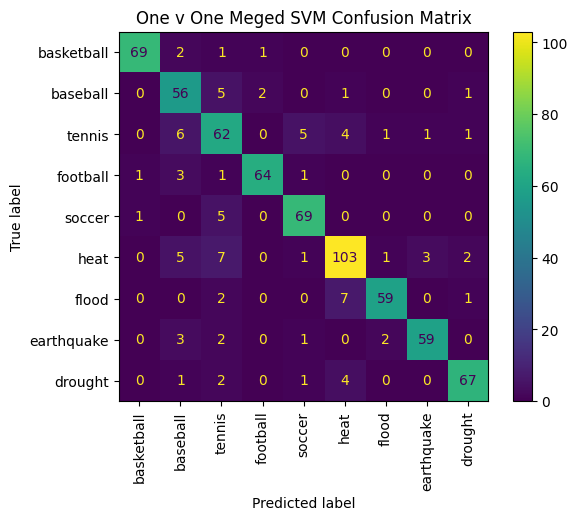

In [ ]:
# one v one combined labels
one_svm = OneVsRestClassifier(LinearSVC(C=10, random_state=42, class_weight='balanced'))
one_svm.fit(train_reduced, train['leaf_label'])
pred = one_svm.predict(test_reduced)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    one_svm,
    test_reduced,
    test["leaf_label"],
    display_labels = ["basketball", "baseball", "tennis",
"football", "soccer", "heat", "flood",
"earthquake", "drought"]
)
disp.ax_.set_title('One v One Meged SVM Confusion Matrix')
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)


print(f'Accuracy Score: {accuracy_score(test["leaf_label"], pred)}')
print("One v One SVM Classification Report:")
print(classification_report(test['leaf_label'], pred, target_names=["basketball", "baseball", "tennis",
"football", "soccer", "heat", "flood",
"earthquake", "drought"]))

Accuracy Score: 0.8735632183908046
One v Rest SVM Classification Report:
              precision    recall  f1-score   support

  basketball       0.97      0.95      0.96        73
    baseball       0.74      0.86      0.79        65
      tennis       0.71      0.78      0.74        80
    football       0.96      0.91      0.93        70
      soccer       0.88      0.92      0.90        75
        heat       0.87      0.84      0.85       122
       flood       0.94      0.86      0.89        69
  earthquake       0.94      0.88      0.91        67
     drought       0.93      0.89      0.91        75

    accuracy                           0.87       696
   macro avg       0.88      0.88      0.88       696
weighted avg       0.88      0.87      0.88       696



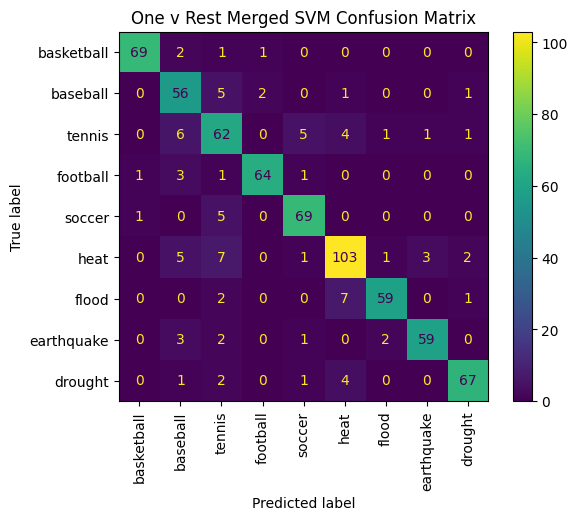

In [ ]:

# One v rest combined labels
rest_svm = OneVsRestClassifier(LinearSVC(random_state=42, C=10, class_weight='balanced'))
rest_svm.fit(train_reduced, train['leaf_label'])
pred = rest_svm.predict(test_reduced)

# confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    rest_svm,
    test_reduced,
    test["leaf_label"],
    display_labels = ["basketball", "baseball", "tennis",
"football", "soccer", "heat", "flood",
"earthquake", "drought"]
)
disp.ax_.set_title('One v Rest Merged SVM Confusion Matrix')
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)


print(f'Accuracy Score: {accuracy_score(test["leaf_label"], pred)}')
print("One v Rest SVM Classification Report:")
print(classification_report(test['leaf_label'], pred, target_names=["basketball", "baseball", "tennis",
"football", "soccer", "heat", "flood",
"earthquake", "drought"]))

**How did the accuracy change in One VS One and One VS
the rest?**

In both one v one and one v rest, the accuracy improved by about 8%.

**Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?**

Merging classes can give unequal weight to the merged class, which could cause the model to overfit towards the merged class. This would have a greater impact in the one v one classifier. In the one v one classification, the merged class in this case would have 2x the amount of samples. In order to eliminate the impact of class imbalance, we used the setting class_weight = balanced.

# GLoVE Embeddings

**QUESTION 10**
**(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?**
The ratio of co-occurrence probabilities gives a better semantic distinction between words in context that we would not get from raw co-occurrance probabilities. This is because it provides context on how likely a word is to appear with another word.

**(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?**

Yes, we would expect the two GLoVE embedding for the word "running" to return the same vector given the two sentences. This is because the GLoVE embedding is alraedy defined for each word, based on the total corpus. Not just the sentence itself. When the embeddings are being trainied, the difference in context would be considered. But when the embeddings are being applied, they are statically applied like a normal dictonary replacement.

**(c) What do you expect for the values of,
||GLoVE["left"] - GLoVE["right"]||2, ||GLoVE["wife"] - GLoVE["husband"]||2 and ||GLoVE["wife"] - GLoVE["orange"]||2 ? Compare these values.**
We would expect the values for wife - husband to be the smallest, since they share very close semantic meaning. We would expect left - right to be the second smallest, since they are semantic opposites. Meaning they share context, but have opposite meanings. We would expect wife - orange to have the greatest distance, because they share no semantic meaning at all.

**(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?**

You would rather lemmatize the word before mapping with a GLoVE embedding because lemmatization will return a real word while stemming may not. Since GLoVE embeddings are created only for real words, you will have a higher probablity of finding a GLoVE mapping for a lemmatized word. Additionally, lemmatization better preserves the meaning of the word in context.

**Question 11**
A process for training a model with GLoVE embeddings could be as follows.
1. Clean data, remove punctuation and stopwords
2. Lemmatize data to get the frequency of word-roots (lemmas)
3. Replace each word word in the lemmatized list with a GLoVE embedding
4. Calculate the average of the list of GLoVE embeddings to get a single vector for the sentence
5. Use these finalized single-vectors to train your classification model

In [ ]:
# QUESTION 11

# upload glove dctionary
glove_dict = {}
with open('/content/glove.6B.300d.txt', 'r', encoding='utf8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_dict[word] = vector

print(glove_dict["the"])

[ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-02  1

In [ ]:
train.head()

,full_text,root_label,lemmatized,glove
0,'While the four-day Aftershock's economic impa...,climate,day aftershock economic impact million day gol...,"[[-0.24501, -0.12491, -0.2536, 0.33819, -0.105..."
1,'CBS Essentials is created independently of th...,sports,cbs essential create independently cbs news ed...,"[[-0.49313, -0.10461, 0.34202, 0.40046, -0.107..."
2,'Moderate-to-severe drought will likely contin...,climate,moderate severe drought likely continue expand...,"[[-0.10605, -0.11819, 0.035605, 0.14476, -0.38..."
3,"'Colleen Flood, the longtime co-owner of The F...",climate,colleen flood longtime owner trey tavern pour ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,sports,washington traffic save life yeah good basebal...,"[[0.033331, -0.10067, 0.00043131, -0.17152, 0...."


In [ ]:
train["glove"], test["glove"] = train['lemmatized'].apply(lambda x: (x.split())), test['lemmatized'].apply(lambda x: (x.split()))


def glove_embed(text, glove_dict):
    return np.array(glove_dict.get(text, np.zeros(300)))

train['glove'], test['glove'] = train['glove'].apply(lambda x: [glove_embed(word, glove_dict) for word in x] ), test['glove'].apply(lambda x: [glove_embed(word, glove_dict) for word in x] )
train['glove'], test['glove'] = train['glove'].apply(lambda x: np.mean(np.array(x), axis=0)), test['glove'].apply(lambda x: np.mean(np.array(x), axis=0))
print(type(train['glove'][0]))
print(type(test['glove'][0]))

train.head()


['day', 'aftershock', 'economic', 'impact', 'million', 'day', 'goldensky', 'festival', 'set', 'estimate', 'million', 'example', 'video', 'title', 'video', 'sacramento', 'calif', 'second', 'year', 'goldensky', 'country', 'music', 'festival', 'book', 'thousand', 'fan', 'take', 'discovery', 'park', 'sacramento', 'organizer', 'look', 'expand', 'event', 'sacramento', 'come', 'party', 'weekend', 'magical', 'weekend', 'say', 'chamie', 'mccurry', 'chief', 'marketing', 'officer', 'danny', 'wimmer', 'present', 'growth', 'year', 'year', 'festival', 'really', 'remarkable', 'heel', 'aftershock', 'organizer', 'say', 'economic', 'impact', 'goldensky', 'festival', 'bring', 'sacramento', 'region', 'wonderful', 'second', 'year', 'phenomenal', 'growth', 'say', 'mike', 'testa', 'ceo', 'visit', 'sacramento', 'testa', 'say', 'day', 'aftershock', 'economic', 'impact', 'million', 'day', 'event', 'set', 'estimate', 'million', 'plan', 'underway', 'year', 'goldensky', 'expand', 'day', 'day', 'festival', 'lot', '

,full_text,root_label,lemmatized,glove
0,'While the four-day Aftershock's economic impa...,climate,day aftershock economic impact million day gol...,"[-0.06266845109104349, -0.006387902291603794, ..."
1,'CBS Essentials is created independently of th...,sports,cbs essential create independently cbs news ed...,"[-0.10344972414890523, 0.22095383065843432, 0...."
2,'Moderate-to-severe drought will likely contin...,climate,moderate severe drought likely continue expand...,"[-0.07907173494589445, 0.015254692044757788, -..."
3,"'Colleen Flood, the longtime co-owner of The F...",climate,colleen flood longtime owner trey tavern pour ...,"[-0.08220576922750637, 0.028869082345413872, -..."
4,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,sports,washington traffic save life yeah good basebal...,"[-0.09324530785493292, 0.10597582338966725, -0..."


In [ ]:
# Train SVC Classifier

X_train, y_train = train['glove'], train['root_label']
X_train = np.vstack(train['glove'].values)
X_test, y_test = test['glove'], test['root_label']
# print(type(X_train)) ## returns pandas.core.series.Series

gamma_range = [10**k for k in range(-3, 7)]
param_grid = {'gamma': gamma_range, 'kernel': ['rbf']}


grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, train["root_label"])
gamma = grid_search.best_params_['gamma']
# gamma = 10
print(gamma)

1


**Results of Best GLoVE Classifier:**

Gamma: 1
CV Accuracy: 95.86%
Test Accuracy: 97.55%

In [ ]:
print("Best CV Accuracy:", grid_search.best_score_)

Best CV Accuracy: 0.9586330935251798


In [ ]:
X_test = np.vstack(test['glove'].values)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.9755747126436781


In [ ]:
# QUESTION 12

def glove_embed(text, glove_dict, dim):
    return np.array(glove_dict.get(text, np.zeros(dim)))

glove_files = {
    50: '/content/glove.6B.50d.txt',
    100: '/content/glove.6B.100d.txt',
    200: '/content/glove.6B.200d.txt',
    300: '/content/glove.6B.300d.txt'
}

for file in glove_files.keys():
  glove_dict = {}
  with open(glove_files[file], 'r', encoding='utf8') as f:
      for line in f:
          parts = line.strip().split()
          word = parts[0]
          vector = np.array(parts[1:], dtype=np.float32)
          glove_dict[word] = vector

  train[f'glove{file}'], test[f'glove{file}'] = train['lemmatized'].apply(lambda x: (x.split())), test['lemmatized'].apply(lambda x: (x.split()))
  train[f'glove{file}'], test[f'glove{file}'] = train[f'glove{file}'].apply(lambda x: [glove_embed(word, glove_dict, file) for word in x] ), test[f'glove{file}'].apply(lambda x: [glove_embed(word, glove_dict, file) for word in x] )
  train[f'glove{file}'], test[f'glove{file}'] = train[f'glove{file}'].apply(lambda x: np.mean(np.array(x), axis=0)), test[f'glove{file}'].apply(lambda x: np.mean(np.array(x), axis=0))

,glove100
0,"[0.01082541105629754, 0.1585592633133659, 0.20..."
1,"[0.007831371644068495, -0.05271753450506367, 0..."
2,"[-0.2524511685927366, 0.11468764230208148, 0.2..."
3,"[0.05521060914087368, 0.1013773907988892, 0.07..."
4,"[-0.016095870115578313, 0.15921466968212314, 0..."


Best Gamma (50): 1
Best CV Accuracy (50): 0.9532374100719425
Best Test Accuracy (50): 0.9626436781609196
Best Gamma (100): 1
Best CV Accuracy (100): 0.953956834532374
Best Test Accuracy (100): 0.9683908045977011
Best Gamma (200): 1
Best CV Accuracy (200): 0.9597122302158272
Best Test Accuracy (200): 0.9727011494252874
Best Gamma (300): 1
Best CV Accuracy (300): 0.9586330935251798
Best Test Accuracy (300): 0.9755747126436781


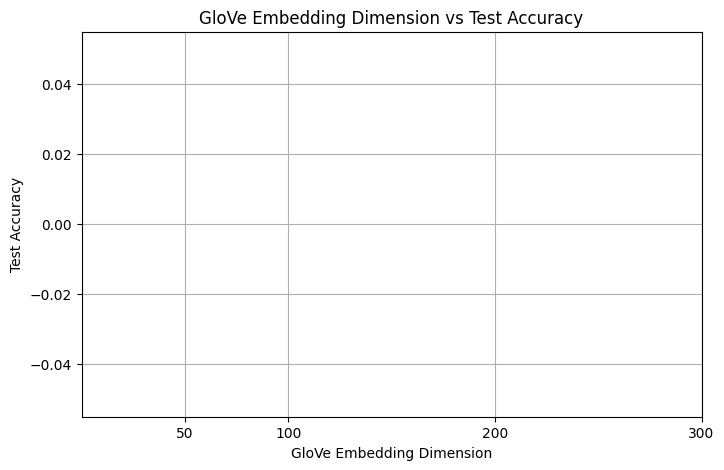

In [ ]:
gridsearch50, gridsearch100, gridsearch200, gridsearch300 = 0, 0, 0, 0
dims = {50: gridsearch50, 100: gridsearch100, 200: gridsearch200, 300: gridsearch300}
gamma_range = [10**k for k in range(-3, 7)]
param_grid = {'gamma': gamma_range, 'kernel': ['rbf']}
results = {}

for dim in dims:

  X_train, y_train = train[f'glove{dim}'], train['root_label']
  X_train = np.vstack(train[f'glove{dim}'].values)
  X_test, y_test = test[f'glove{dim}'], test['root_label']



  dims[dim] = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
  dims[dim].fit(X_train, train["root_label"])
  gamma = dims[dim].best_params_['gamma']

  X_test = np.vstack(test[f'glove{dim}'].values)
  best_model = dims[dim].best_estimator_
  y_pred = best_model.predict(X_test)
  # Accuracy on test set
  test_acc = accuracy_score(y_test, y_pred)
  results[dim] = test_acc


  print(f'Best Gamma ({dim}): {gamma}')
  print(f"Best CV Accuracy ({dim}):", dims[dim].best_score_)
  print(f"Best Test Accuracy ({dim}):", test_acc)



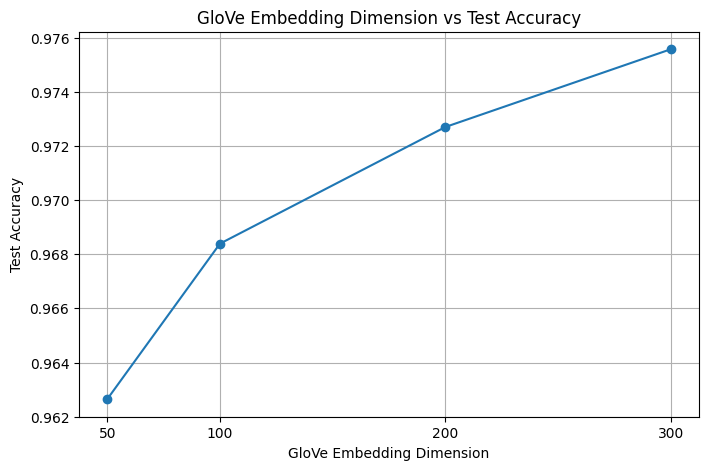

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title("GloVe Embedding Dimension vs Test Accuracy")
plt.xlabel("GloVe Embedding Dimension")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(list(results.keys()))
plt.show()

There was an observed trend that an increase in dimensionality correlated with an increase in test accuracy. This is expected because the higher the dimension, the more detailed information we can store on the semantic context of each word.

It is also noticed that there is a pattern of decreasing marginal gains as the demension is increased.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-74-dfc32746d005>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_glove_umap[:, 0], X_glove_umap[:, 1], cmap='coolwarm', alpha=0.7, s=10)


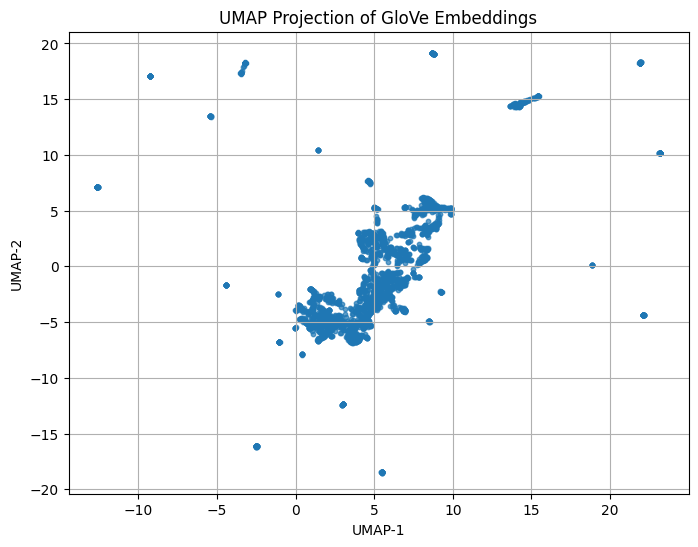

In [74]:
# QUESTION 13
# import umap
x_glove = np.vstack(train['glove300'].values)
y_glove = train['root_label'].values

# UMAP projection
reducer = umap.UMAP(random_state=42)
X_glove_umap = reducer.fit_transform(x_glove)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_glove_umap[:, 0], X_glove_umap[:, 1], cmap='coolwarm', alpha=0.7, s=10)
plt.title("UMAP Projection of GloVe Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-76-e3e6b90d2f8a>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_glove_umap[:, 0], X_glove_umap[:, 1], cmap='coolwarm', alpha=0.7, s=10)


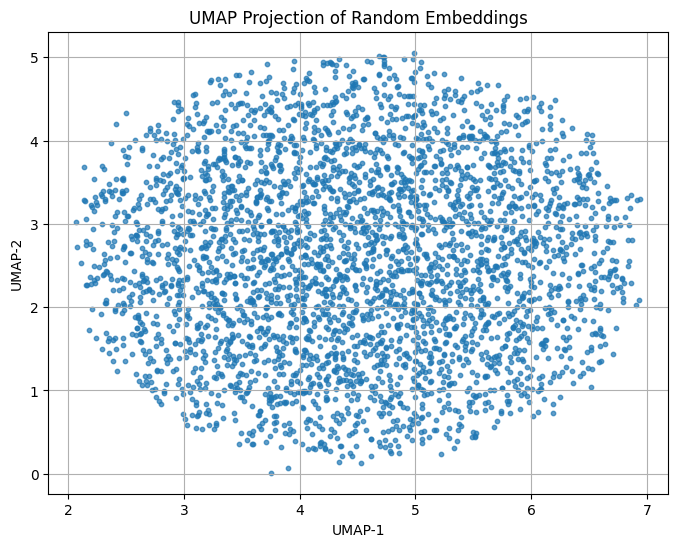

In [76]:
X_random = np.random.rand(len(df), dim)
# X_random = normalize(X_random)
X_glove_umap = reducer.fit_transform(X_random)

plt.figure(figsize=(8, 6))
plt.scatter(X_glove_umap[:, 0], X_glove_umap[:, 1], cmap='coolwarm', alpha=0.7, s=10)
plt.title("UMAP Projection of Random Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

As expected, we see the plot of GLoVE embeddings mapping to two distinct classes show a clustered representation within the data. The random vectors, by definition, show no clustering or patterns.